In [0]:
# eec266_project.ipynb
# Author: Mason del Rosario
# Replicate numerical results (Figures 2, 3, and 4) from 2010 paper, "Maximum Mutual Information Design for MIMO Systems With Imperfect Channel Knowledge" (Ding, Blostein)
import numpy as np
from scipy.linalg import sqrtm
import functools as ft
import time

# subclass ndarray to include Hermitian
class complex_array(np.ndarray):
    @property
    def H(self):
        return self.conj().T

In [0]:
# parameters for system model
n_T = 4 # transmitter antennas
n_R = 4 # receiver antennas
rho_T = 0.9 # correlation constant for R_T
rho_R = 0.5 # correlation constant for R_R
var_E = 0.01 # error variance
var_n = 0.01 # noise variance

In [0]:
# core function: iterative solver for MMSE precoder/decoder pair yielding opt. covariance matrix for Capacity Lower Bound
def precoder_solver(Hhat,R_T,R_R,P_T,eps=0.01,uni_bool=False):
    # Step 1: F initialized as scaled version of the identity.
    r_g = np.linalg.matrix_rank(Hhat)
    F = np.sqrt(P_T)/r_g*np.eye(r_g).view(complex_array)
    MSE_iter = 10
    i = 0
    # only use iterative algorithm if we aren't returning
    if uni_bool==False:
        while (MSE_iter > eps):
            Q = np.matmul(F,F.H)
            # step 2: update Rn_total, then G (decoder)
            Rn_total = total_noise(R_T,R_R,var_E,Q,var_n)
            G = decoder(F,Hhat,Rn_total)
            # step 3: update lagrangian multipliers, mu and alpha
            mu_g = mu(var_n,P_T,G,Rn_total,Hhat,F)
            alpha_g = alpha(G,R_R,Rn_total,Hhat,F)
            # step 4: update F (precoder)
            F_n = precoder(mu_g,alpha_g,var_E,R_T,Hhat,G,P_T)
            # MSE_iter = np.linalg.norm(F_n-F) # numpy norm is Frob norm by default
            temp = F_n-F
            MSE_iter = np.sqrt(np.trace(temp*temp.H)) # explicit def for Frob norm
            F = F_n
            i=i+1
    else:
        Q = np.matmul(F,F.H)
        Rn_total = total_noise(R_T,R_R,var_E,Q,var_n)
    return F, Rn_total

# helper function: update total noise (2)
def total_noise(R_T,R_R,var_E,Q,var_n):
    n_R = np.shape(R_R)[0]
    return var_E*np.trace(np.matmul(R_T,Q))*R_R+var_n*np.eye(n_R,dtype=complex)

# helper function: update decoder, G (29/Step 2 in Table 1)
def decoder(F,Hhat,Rn_total):
    g1 = np.matmul(F.H,Hhat.H)
    g2 = np.linalg.inv(ft.reduce(np.matmul,[Hhat,F,F.H,Hhat.H])+Rn_total)
    return np.matmul(g1,g2)

# helper function: update lagrangian multiplier, mu (37)
def mu(var_n,P_T,G,Rn_total,Hhat,F):
    temp = ft.reduce(np.matmul,[G,np.linalg.inv(Rn_total),Hhat,F])
    return var_n/P_T*np.trace(temp)

# helper function: update lagrangian multiplier, alpha (33)
def alpha(G,R_R,Rn_total,Hhat,F):
    temp = ft.reduce(np.matmul,[G,R_R,np.linalg.inv(Rn_total),Hhat,F])
    return np.trace(temp)

# helper function: update precoder, F (34/Step 4 in Table 1)
def precoder(mu_g,alpha_g,var_E,R_T,Hhat,G,P_T):
    n_T = R_T.shape[0]
    temp = np.linalg.inv(mu_g*np.eye(n_T)+alpha_g*var_E*R_T)
    F = ft.reduce(np.matmul,[temp,Hhat.H,G.H])
    # scale s.t. tr(F*F.H)=P_T
    F_scale = np.sqrt(P_T/np.trace(np.matmul(F,F.H)))
    return F_scale*F

# core function: circularly symmetric complex normal distribution
def circ_complex_normal(m, n, mean=None, cov=None):
    if type(mean)==type(None):
        mean = np.zeros(2)
    if type(cov)==type(None):
        cov = np.eye(2)
    # generate i.i.d complex samples
    re,im = np.random.multivariate_normal(mean, cov, m*n).T
    out = np.zeros((m,n),dtype=complex)
    k=0
    for i in range(m):
        for j in range(n):
            temp = re[k] + 1j*im[k]
            out[i,j] = temp
            k=k+1
    return out

# core function: random data vector for calculating capacity upper-bound 
def data_vector(n_T,Q):
    mean = np.zeros(2)
    re,im = np.random.multivariate_normal(mean, Q, m*n).T
    out = np.zeros((n_T,1),dtype=complex)
    for i in range(m):
        temp = re[i] + 1j*im[i]
        out[i] = temp
    return out

# core function: exponential correlation model from Aalto, 1995
def exponential_corr(n, rho):
    # inputs:
    # -> n = # of antennas
    # -> rho = correlation constant for exponential correlation model
    R = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            R[i,j] = rho**(np.abs(i-j))
    R = symmetrize(R)
    return R

# helper function: symmetrize
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [0]:
# helper function: exponential correlation matrices
def corr_matrices(n_T,n_R,rho_T,rho_R):
    R_T = exponential_corr(n_T,rho_T)
    R_R = exponential_corr(n_R,rho_R)
    return R_T, R_R

# helper function: channel realization; generate CSI and CSI estimate
def channel_realization(n_T,n_R,R_T,R_R,var_E,var_n,scale=1.0):
    # i.i.d. circularly symmetric complex normal matrices for system model
    H_w = circ_complex_normal(n_T,n_R).view(complex_array) # csi estimate sampled using unit covariance matrix
    Hhat_cov = scale*(1-var_E)*np.eye(2) # csi estimate covariance matrix
    Hhat_w = circ_complex_normal(n_T,n_R,cov=Hhat_cov).view(complex_array)
    # H from correlation matrices and H_w
    H = sqrtm(R_R)*H_w*sqrtm(R_T)
    Hhat = sqrtm(R_R)*Hhat_w*sqrtm(R_T)
    return H,Hhat

In [0]:
# helper function: mutual information for MIMO channel capacity Lower Bound
def mutual_info_LB(n_R,Hhat,F,Rn_total):
    # mutual information as defined in (3) from the paper
    # assume we have optimal precoder to calculate optimal Q
    Q = np.matmul(F,F.H)
    temp = np.eye(n_R)+ft.reduce(np.matmul,[Hhat,Q,Hhat.H,np.linalg.inv(Rn_total)])
    return np.log2(np.linalg.det(temp))

def mutual_info_UB(Rn_total,var_E,F,R_T,R_R,var_N,n_R,n=int(10e3)):
    Q = np.matmul(F,F.H)
    temp1 = np.log2(np.linalg.det(Rn_total))
    temp2 = np.log2(np.linalg.det(var_E*(R_T*Q)*R_R+var_N*np.eye(n_R)))
    return temp1-temp2

In [0]:
# iterate through channel realizations to get capacity lower bound
def get_capacity_LB(var_n,P_T,n_T,n_R,rho_T,rho_R,var_E=0.01,uni_bool=False,hi_bool=False,samples=500,div=100):
    MI_samples = []
    MI_hi_samples = []
    for k in range(samples):
        if div != 0 and k % div == 0:
            print('-> iteration #{}'.format(k))
        R_T, R_R = corr_matrices(n_T,n_R,rho_T,rho_R)
        H, Hhat = channel_realization(n_T,n_R,R_T,R_R,var_E,var_n)
        F, Rn_total = precoder_solver(Hhat,R_T,R_R,P_T,uni_bool=uni_bool)
        MI_lo = mutual_info_LB(n_R,Hhat,F,Rn_total)
        MI_samples.append(MI_lo)
        if hi_bool:
            MI_hi = mutual_info_UB(Rn_total,var_E,F,R_T,R_R,var_n,n_R)
            MI_hi_samples.append(MI_hi)
    C_low = np.mean(MI_samples)
    if hi_bool:
        hi_temp = np.mean(MI_hi_samples)
        C_hi = C_low+hi_temp
        return C_low, C_hi
    else:
        return C_low


In [0]:
# timer class for tracking/projecting iteration finishing time
# adapted from Eli Bendersky's stackoverflow answer to "what is the python equivalent of matlabs tic and toc functions"
class Timer(object):
    def __init__(self,name=None,target=8):
        self.name = name
        self.finished = 0
        self.times = []
        self.target = target
    
    def __enter__(self):
        self.tstart = time.time()
    
    def __exit__(self, type, value, traceback):
        self.finished = self.finished + 1
        self.elapsed = time.time() - self.tstart
        self.times.append(self.elapsed)
        self.avg_time = np.mean(self.times)
        self.projected_time = (self.target - self.finished)*self.avg_time
        print('--- {}-> Time Elapsed: {:2.2f} minutes - ETA: {:2.2f} minutes for {} cases ---'.format(self.name,np.sum(self.times)/60,self.projected_time/60,self.target-self.finished))
    
    def get_times(self):
        return self.times

In [8]:
P_T = 0.1
# dicts with [rho_T,rho_R] values for exponential correlation
fig2_cases = {
    0: [0.5,0.0,'hi'],
    1: [0.9,0.0,'hi'],
    2: [0.5,0.0,0], # perfect
    3: [0.9,0.0,0], # perfect
    4: [0.5,0.0,'uni'],
    5: [0.9,0.0,'uni']
}
fig2_extra_ind = [6,7]
fig3_cases = {
    0: [0.0,0.0],
    1: [0.5,0.0],
    2: [0.5,0.5],
    3: [0.9,0.0]
}
fig4_cases = {
    0: [0.5,0.0],
    1: [0.0,0.5],
    2: [0.9,0.0],
    3: [0.0,0.9]
}

fig_cases = [fig2_cases, fig3_cases, fig4_cases]
snr_list = [x for x in range(0,40,4)]
cap_out_list = []
time_list = []
num_done = 0
target = len(fig2_cases)+len(fig3_cases)+len(fig4_cases)
timer = Timer("Outer Timer",target=target)
extra_ind = 0
print("Running simulations for Figures 2 through 4.")
for k in range(len(fig_cases)):
    fig_case = fig_cases[k]
    cap_dict = {}
    for l in range(len(fig_case)):
        with timer:
            cap_list = []
            print(fig_case)
            if len(fig_case[l])==2:
                rho_T,rho_R  = fig_case[l]
                var_E = 0.01
                uni_bool = False
                hi_bool = False
            elif fig_case[l][2]==0:
                # var_E = 0 => perfect CSI
                rho_T,rho_R,var_E = fig_case[l]
                uni_bool = False
                hi_bool = False
            elif fig_case[l][2]=='hi':
                # include upper bound
                rho_T,rho_R,_ = fig_case[l]
                var_E = 0.01
                uni_bool = False
                hi_bool = True
                cap_hi_list = []
            elif fig_case[l][2]=='uni':
                rho_T,rho_R, _ = fig_case[l]
                var_E = 0.01
                uni_bool = True
                hi_bool = False
            timer_in = Timer("Inner Timer",target=len(snr_list))
            for snr in snr_list:
                with timer_in:
                    print('case: {}, rho_T={},rho_R={}, snr={}'.format(l,rho_T,rho_R,snr))
                    var_n = P_T / (10**(snr/10))
                    print('var_n: {}'.format(var_n))
                    cap = get_capacity_LB(var_n,P_T,n_T,n_R,rho_T,rho_R,var_E=var_E,uni_bool=uni_bool,hi_bool=hi_bool)
                    if hi_bool:
                        cap, cap_hi = cap
                        print('capacity: {}'.format(cap))
                        cap_list.append(cap)
                        cap_hi_list.append(cap_hi)
                    else:
                        print('capacity: {}'.format(cap))
                        cap_list.append(cap)
            cap_dict[l] = cap_list
            if hi_bool:
                cap_dict[fig2_extra_ind[extra_ind]] = cap_hi_list
                extra_ind = extra_ind + 1
    cap_out_list.append(cap_dict)

all_times = timer.get_times()

Running simulations for Figures 2 through 4.
{0: [0.5, 0.0, 'hi'], 1: [0.9, 0.0, 'hi'], 2: [0.5, 0.0, 0], 3: [0.9, 0.0, 0], 4: [0.5, 0.0, 'uni'], 5: [0.9, 0.0, 'uni']}
case: 0, rho_T=0.5,rho_R=0.0, snr=0
var_n: 0.1
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (2.434013055724824-8.26740188718534e-19j)
--- Inner Timer-> Time Elapsed: 0.05 minutes - ETA: 0.42 minutes for 9 cases ---
case: 0, rho_T=0.5,rho_R=0.0, snr=4
var_n: 0.03981071705534973
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (4.258813468271457+2.20820290558161e-18j)
--- Inner Timer-> Time Elapsed: 0.09 minutes - ETA: 0.37 minutes for 8 cases ---
case: 0, rho_T=0.5,rho_R=0.0, snr=8
var_n: 0.015848931924611134
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (6.7389695549932185+1.4651296208340275e-18j)
--- Inner Timer-> Time Elapsed: 0.15 minutes - ETA: 0.34 minutes for 7 ca

--- Science/IEEE matplotlib styles unavailable. Render with default matplotlib style. ---


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


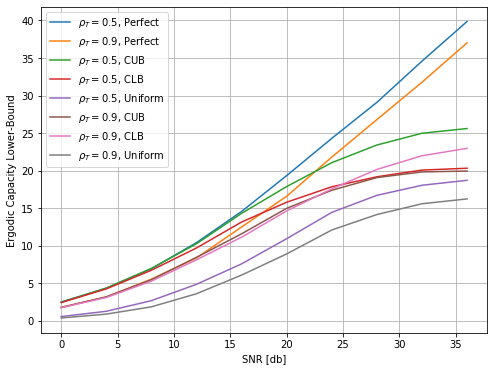

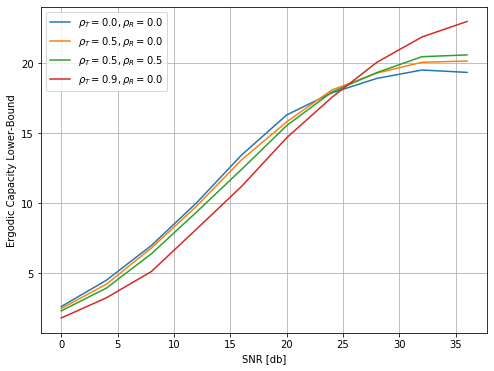

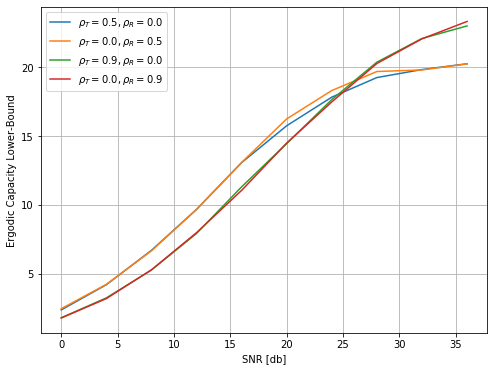

In [10]:
# Figure 3,4: plot capacity lower bounds for different correlation matrices
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# check for science/ieee matplotlib styles
try:
  plt.style.use(['science','ieee','muted'])
  save_bool = True
except:
  print("--- Science/IEEE matplotlib styles unavailable. Render with default matplotlib style. ---")
  save_bool = False
# Labels for plotting
# for fig2
fig2_labels = {
    0: r'$\rho_T=0.5$, CLB',
    1: r'$\rho_T=0.9$, CLB',
    2: r'$\rho_T=0.5$, Perfect',
    3: r'$\rho_T=0.9$, Perfect',
    4: r'$\rho_T=0.5$, Uniform',
    5: r'$\rho_T=0.9$, Uniform',
    6: r'$\rho_T=0.5$, CUB',
    7: r'$\rho_T=0.9$, CUB'
} 
fig2_order = [2,3,6,0,4,7,1,5]
# for fig3
fig3_labels = {
    0: r'$\rho_T=0.0,\rho_R=0.0$',
    1: r'$\rho_T=0.5,\rho_R=0.0$',
    2: r'$\rho_T=0.5,\rho_R=0.5$',
    3: r'$\rho_T=0.9,\rho_R=0.0$'
} 
# for fig4
fig4_labels = {
    0: r'$\rho_T=0.5,\rho_R=0.0$',
    1: r'$\rho_T=0.0,\rho_R=0.5$',
    2: r'$\rho_T=0.9,\rho_R=0.0$',
    3: r'$\rho_T=0.0,\rho_R=0.9$'
} 
labels_list = [fig2_labels,fig3_labels,fig4_labels]
fig_names = ['fig2_final','fig3_final','fig4_final']
for j in range(len(labels_list)):
    fig, ax = plt.subplots(figsize=(8,6))
    cap_dict = cap_out_list[j]
    labels = labels_list[j]
    for i in range(len(labels)):
        if j==0: # shenanigans to handle reordering traces
            ind=fig2_order[i]
        else:
            ind=i
        ax.plot(snr_list, cap_dict[ind],label=labels[ind])
    ax.set(xlabel='SNR [db]', ylabel='Ergodic Capacity Lower-Bound')
    ax.grid()
    ax.legend()
    # ax.set_title("{}".format(fig_names_long[j]))
    plt.show()
    if save_bool:
      fig.savefig("figures/{}.png".format(fig_names[j]))
    